# Combined method which generates trajectories by:
Generate N trajectories with following steps:
- Choose which model to apply (const vel or const vel with angle)
  - choose base velocity and angle either from average velocity or discounted average velocity
- At each predict timestep randomly apply:
  - velocity change
  - angle change
  - randomly stopping

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
import scipy.stats as st
#np.random.seed(42)

In [2]:
# Edinburgh
from data_processing import read_edinburgh_data 
edinburgh_data, edinburgh_agent_ids = read_edinburgh_data()

/Users/kriis/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


reading:./OpenTraj/datasets/Edinburgh/annotations/tracks.01Sep.txt


100%|███████████████████████████████████████| 2342/2342 [01:01<00:00, 37.97it/s]


Warning! too big dt in [Edinburgh]
finish


## Helper methods

### Data preparation

In [3]:
def agent_data(data, agent_id):
    x = data["pos_x"].loc[data["agent_id"]==agent_id].values
    y = data["pos_y"].loc[data["agent_id"]==agent_id].values

    max_train_idx = len(x)-10
    
    return x, y, max_train_idx

# Sample train and test data for pos_x and pos_y, each slice with num_steps length
def generate_data(data, begin_idx, agent_id, num_steps=5):
    sample_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values
    sample_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values

    test_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    test_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    
    return sample_x, sample_y, test_x, test_y
    
def calculate_FDE(pred_x, pred_y, test_x, test_y):

    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    return FDE

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [4]:
def kernel_density_estimation(x_data, y_data, start_idx, all_final_x, all_final_y):
    all_final_x = np.array(all_final_x)
    all_final_y = np.array(all_final_y)
    
    xmin, xmax = min(all_final_x), max(all_final_x)
    ymin, ymax = min(all_final_y), max(all_final_y)
    
    xdiff = xmax - xmin
    ydiff = ymax - ymin
    
    xmin = xmin - 0.5*xdiff
    xmax = xmax + 0.5*xdiff
    
    ymin = ymin - 0.5*ydiff
    ymax = ymax + 0.5*ydiff
    
    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:300j, ymin:ymax:300j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([all_final_x, all_final_y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    plot_KDE(x_data, y_data, start_idx, xx, yy, f)
    plot_KDE_w_whole_trajectory(x_data, y_data, start_idx, xx, yy, f)

### Plotting

In [30]:
def plot_KDE(x_data, y_data, start_idx, xx, yy, f):
    plt.figure(figsize=(10, 10))
    plt.axes().set_aspect('equal')
    plt.grid(alpha=0.5)
    plt.xlim(-12, 0)
    plt.ylim(-3, 6)
    
    #CS = plt.contour(xx, yy, f, levels=[0.001, 0.002, 0.005, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56])
    CS = plt.contour(xx, yy, f, levels=[0.005, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56])
    plt.clabel(CS, inline=1, fontsize=10)
    
    plt.plot(x_data[start_idx:start_idx+5], y_data[start_idx:start_idx+5], c='b')
    plt.scatter(x_data[start_idx:start_idx+5], y_data[start_idx:start_idx+5], c='b')
    
    #plt.scatter(x_data[start_idx], y_data[start_idx], c='blue', linewidth=3)
    
    #plt.scatter(x_data[start_idx+5:start_idx+10], y_data[start_idx+5:start_idx+10], c='red')
    #plt.plot(x_data[start_idx+5-1:start_idx+10], y_data[start_idx+5-1:start_idx+10], '--', c='red')
    plt.show()
    
def plot_KDE_w_whole_trajectory(x_data, y_data, start_idx, xx, yy, f):
    plt.figure(figsize=(10, 10))
    plt.axes().set_aspect('equal')
    
    #CS = plt.contour(xx, yy, f, levels=[0.001, 0.002, 0.005, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56])
    CS = plt.contour(xx, yy, f, levels=[0.005, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56])
    plt.clabel(CS, inline=1, fontsize=10)
    
    plt.plot(x_data, y_data, c='b')
    plt.scatter(x_data, y_data, c='b')
    
    #plt.scatter(x_data[0], y_data[0], c='blue', linewidth=3)
    
    plt.plot(x_data[start_idx:start_idx+5], y_data[start_idx:start_idx+5], c='yellow')
    plt.scatter(x_data[start_idx:start_idx+5], y_data[start_idx:start_idx+5], c='yellow')
    
    plt.plot(x_data[start_idx+5:start_idx+10], y_data[start_idx+5:start_idx+10], c='orange')
    plt.scatter(x_data[start_idx+5:start_idx+10], y_data[start_idx+5:start_idx+10], c='orange')
    plt.show()
    
def plot_all_trajectories(x_data, y_data, pred_xs, pred_ys, start_idx, finalize_plot = True):
    plt.figure(figsize=(10, 10))
    plt.axes().set_aspect('equal')
    plt.grid(alpha=0.5)
    
    plt.plot(x_data, y_data, c='b', label='seen trajectory')
    plt.scatter(x_data, y_data, c='b')
    
    plt.scatter(x_data[0], y_data[0], c='blue', linewidth=3)
    
    plt.plot(x_data[start_idx:start_idx+5], y_data[start_idx:start_idx+5], c='yellow')
    plt.scatter(x_data[start_idx:start_idx+5], y_data[start_idx:start_idx+5], c='yellow')
    
    plt.plot(x_data[start_idx+5:start_idx+10], y_data[start_idx+5:start_idx+10], c='orange')
    plt.scatter(x_data[start_idx+5:start_idx+10], y_data[start_idx+5:start_idx+10], c='orange')
    
    for i in range(len(pred_xs)):
        plt.plot(pred_xs[i], pred_ys[i], linewidth=0.25)
    
    if finalize_plot:
        plt.show()
        
def plot_all_trajectories_with_only_train(sample_x, sample_y, pred_xs, pred_ys, start_idx, finalize_plot = True):
    plt.figure(figsize=(10, 10))
    plt.axes().set_aspect('equal')
    plt.grid(alpha=0.5)
    
    plt.plot(sample_x, sample_y, c='b', label='seen trajectory')
    plt.scatter(sample_x, sample_y, c='b')
    
    #plt.scatter(x_data[0], y_data[0], c='blue', linewidth=3)
    
    for i in range(len(pred_xs)):
        plt.plot(pred_xs[i], pred_ys[i], linewidth=0.25)
    
    if finalize_plot:
        #plt.legend()
        plt.show()

## Model

In [12]:
def get_model(params):
    if np.random.rand() < params['CONST_VEL_MODEL_PROB']:
        return 'CONST_VEL'
    else:
        return 'CONST_VEL_W_ROTATION'
    
def get_action(params):
    if np.random.rand() < params['STOP_PROB']:
        return 'STOP'
    if np.random.rand() < params['VELOCITY_CHANGE_PROB']:
        return 'VELOCITY_CHANGE'
    if np.random.rand() < params['ANGLE_CHANGE_PROB']:
        return 'ANGLE_CHANGE'
    return None

# Decide whether to use average or discounted average as const velocity
def get_const_vel(params, sample_vel_x, sample_vel_y):
    if np.random.rand() < params['DISCOUNT_AVG_PROB']:
        discount = np.random.uniform(low=params['DISCOUNT_LOWER_BOUND'])
        const_vel_x = (discount**3*sample_vel_x[0] + discount**2*sample_vel_x[1] + discount*sample_vel_x[2] + sample_vel_x[3]) / (discount**3 + discount**2 + discount + 1)
        const_vel_y = (discount**3*sample_vel_y[0] + discount**2*sample_vel_y[1] + discount*sample_vel_y[2] + sample_vel_y[3]) / (discount**3 + discount**2 + discount + 1)
    else:
        const_vel_x = np.mean(sample_vel_x)
        const_vel_y = np.mean(sample_vel_y)
        
    return const_vel_x, const_vel_y

# Decide whether to use average or discounted average angle
def get_angle(sample_vel_x, sample_vel_y):
    all_angles = []
    for i in range(1, len(sample_vel_x)):
        prev_vel = [sample_vel_x[i-1], sample_vel_y[i-1]]
        curr_vel = [sample_vel_x[i], sample_vel_y[i]]
        one_angle = np.math.atan2(np.linalg.det([prev_vel, curr_vel]),np.dot(prev_vel, curr_vel))   
        all_angles.append(one_angle)
    
    if np.random.rand() < params['DISCOUNT_AVG_PROB']:
        discount = np.random.uniform(low=params['DISCOUNT_LOWER_BOUND'])
        angle = (discount**2*all_angles[0] + discount*all_angles[1] + all_angles[2]) / (discount**2 + discount + 1)
    else:
        angle = np.mean(all_angles)
    return angle

def predict_one_trajectory(sample_x, sample_y, params):
    # calculate velocity data
    sample_vel_x = [(sample_x[i] - sample_x[i-1]) + np.random.normal(0, params['NOISE']) for i in range(1, len(sample_x))]
    sample_vel_y = [(sample_y[i] - sample_y[i-1]) + np.random.normal(0, params['NOISE']) for i in range(1, len(sample_y))]
    
    const_vel_x, const_vel_y = get_const_vel(params, sample_vel_x, sample_vel_y)
    angle = get_angle(sample_vel_x, sample_vel_y)
    
    # start predicting
    pred_x = []
    pred_y = []
    model = get_model(params)
    for i in range(5):
        action = get_action(params)
        if action == 'STOP':
            if len(pred_x) == 0:
                pred_x.append(sample_x[-1])
                pred_y.append(sample_y[-1])
            else:
                pred_x.append(pred_x[-1])
                pred_y.append(pred_y[-1])
            continue
            
        elif action == 'VELOCITY_CHANGE':
            const_vel_x = const_vel_x + np.random.normal(0, params['VELOCITY_CHANGE_NOISE'])
            const_vel_y = const_vel_y + np.random.normal(0, params['VELOCITY_CHANGE_NOISE'])
        elif action == 'ANGLE_CHANGE':
            angle = angle + np.random.normal(0, params['ANGLE_CHANGE_NOISE'])
        
        if model == 'CONST_VEL':
            if len(pred_x) == 0:
                pred_x.append(sample_x[-1] + const_vel_x)
                pred_y.append(sample_y[-1] + const_vel_y)
            else:
                pred_x.append(pred_x[-1] + const_vel_x)
                pred_y.append(pred_y[-1] + const_vel_y)
        elif model == 'CONST_VEL_W_ROTATION':
            if len(pred_x) == 0:
                prev_x = sample_x[-2]
                prev_y = sample_y[-2]
                cur_x = sample_x[-1] + const_vel_x
                cur_y = sample_y[-1] + const_vel_y
            else:
                prev_x = pred_x[-1]
                prev_y = pred_y[-1]
                cur_x = pred_x[-1] + const_vel_x
                cur_y = pred_y[-1] + const_vel_y
            rot_x, rot_y = rotate((prev_x, prev_y), (cur_x, cur_y), angle)
            pred_x.append(rot_x)
            pred_y.append(rot_y)
            
            # redefine the average velocity as it now has a new heading
            const_vel_x = rot_x - prev_x
            const_vel_y = rot_y - prev_y
        
    return pred_x, pred_y
            

## KDE plotting

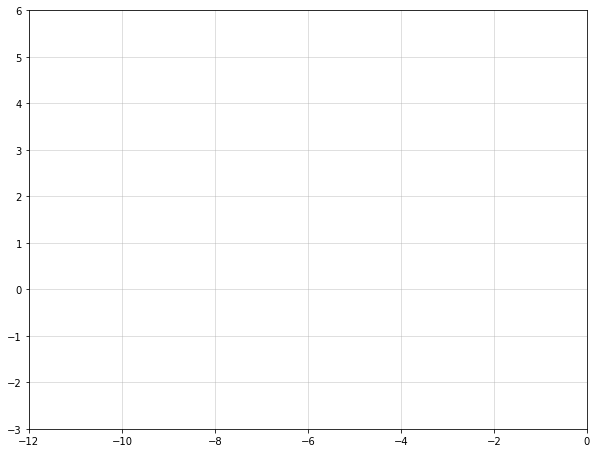

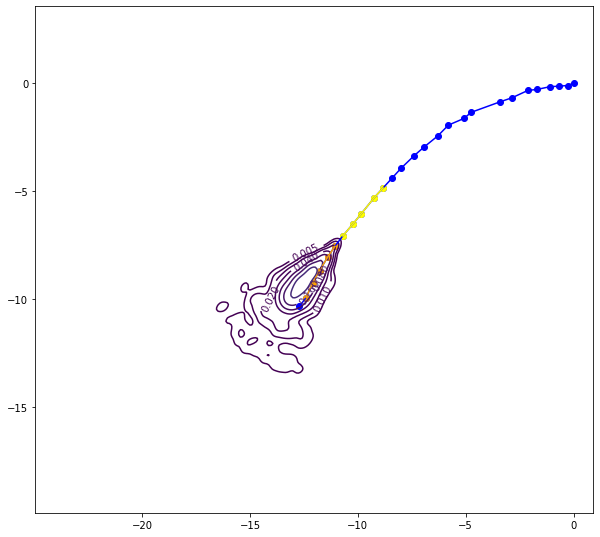

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


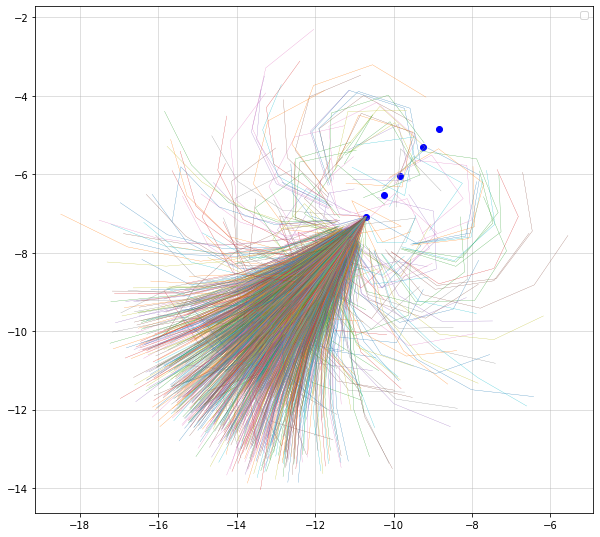

In [13]:
params = {
    "NOISE": 0.1,
    "NO_OF_TRAJECTORIES": 10000,
    "CONST_VEL_MODEL_PROB": 0.8,
    
    "STOP_PROB": 0.2,
    
    "DISCOUNT_AVG_PROB": 0.5,
    "DISCOUNT_LOWER_BOUND": 0.5,
    
    "VELOCITY_CHANGE_PROB": 0.2,
    "VELOCITY_CHANGE_NOISE": 0.1,
    
    "ANGLE_CHANGE_PROB": 0.05,
    "ANGLE_CHANGE_NOISE": 1
}

for agent_id in edinburgh_agent_ids[:1]:
    x_data, y_data, max_train_idx = agent_data(edinburgh_data, agent_id)
    start_idx = np.random.randint(0, max_train_idx)
    sample_x, sample_y, test_x, test_y = generate_data(edinburgh_data, start_idx, agent_id, 5)
    
    all_pred_x, all_pred_y = [], []
    all_final_x, all_final_y = [], []
    for i in range(params['NO_OF_TRAJECTORIES']):
        pred_x, pred_y = predict_one_trajectory(sample_x, sample_y, params)
        #print(pred_x)
        all_pred_x.append(pred_x)
        all_pred_y.append(pred_y)
        
        all_final_x.append(pred_x[-1])
        all_final_y.append(pred_y[-1])
        
    kernel_density_estimation(x_data, y_data, start_idx, all_final_x, all_final_y)
    #plot_all_trajectories(x_data, y_data, all_pred_x, all_pred_y, start_idx)
    # plots for the presentation
    plot_all_trajectories_with_only_train(sample_x, sample_y, all_pred_x, all_pred_y, start_idx)
    print("======================================================")
    print("======================================================")

### Creating predicted clusters/trajectories

In [14]:
from sklearn.cluster import KMeans

def run_KMeans(pred_x_list, pred_y_list, no_of_clusters):
    final_points = []
    # this can be optimized as this is done in the parent method already
    for i in range(len(pred_x_list)):
        final_points.append([pred_x_list[i][-1], pred_y_list[i][-1]])
    
    Kmean = KMeans(n_clusters=no_of_clusters)
    Kmean.fit(final_points)

    cluster_avg_x, cluster_avg_y, no_of_elements_per_cluster = get_clustered_averages(pred_x_list, pred_y_list, no_of_clusters, Kmean.labels_)
    # Should probably also return labels or do the averaged clusters already contain them?
    return cluster_avg_x, cluster_avg_y, no_of_elements_per_cluster

def get_clustered_averages(all_pred_x, all_pred_y, no_of_clusters, cluster_labels):
    no_of_elements_per_cluster = []
    for i in range(no_of_clusters):
        no_of_elements_per_cluster.append((cluster_labels == i).sum())
    
    clustered_preds_x = [[] for _ in range(no_of_clusters)]
    clustered_preds_y = [[] for _ in range(no_of_clusters)]

    for idx, cluster_label in enumerate(cluster_labels):
        clustered_preds_x[cluster_label].append(all_pred_x[idx])
        clustered_preds_y[cluster_label].append(all_pred_y[idx])
        
    cluster_avg_x = [[] for _ in range(no_of_clusters)]
    cluster_avg_y = [[] for _ in range(no_of_clusters)]
    
    for i in range(no_of_clusters):
        cluster_avg_x[i] = np.mean(clustered_preds_x[i], axis=0)
        cluster_avg_y[i] = np.mean(clustered_preds_y[i], axis=0)
        
    return cluster_avg_x, cluster_avg_y, no_of_elements_per_cluster

In [31]:
def create_predicted_trajectories(sample_x, sample_y, params, plotting_data=None):
    all_pred_x, all_pred_y = [], []
    all_final_x, all_final_y = [], []
    
    for i in range(params['NO_OF_TRAJECTORIES']):
        pred_x, pred_y = predict_one_trajectory(sample_x, sample_y, params)
        #print(pred_x)
        all_pred_x.append(pred_x)
        all_pred_y.append(pred_y)
        
        all_final_x.append(pred_x[-1])
        all_final_y.append(pred_y[-1])
    
    # run kernel density estimate
    values = np.vstack([all_final_x, all_final_y])
    kernel = st.gaussian_kde(values)
    # evaluate trajectories
    evaluated = kernel.evaluate(values)
    # find the sorting order for the trajectories based on KDE pdf
    sorting_order = evaluated.argsort()[::-1] # Note: the sorting order is ascending by default, [::-1] reverses the order (might be too slow though?)
    
    # sort predictions by KDE density
    sorted_all_pred_x = np.array(all_pred_x)[sorting_order]
    sorted_all_pred_y = np.array(all_pred_y)[sorting_order]
    
    # distribute the data to representative sets
    no_of_traj = len(sorted_all_pred_x)

    '''
    # find the closest 20% of trajectories for the highest density trajectory
    highest_density_x = sorted_all_pred_x[0]
    highest_density_y = sorted_all_pred_y[0]
    largest_distance = None
    closest_indexes = np.array([], dtype=np.int8)
    closest_distances = np.array([])
    
    for idx in range(len(sorted_all_pred_x)):
        distance = calculate_FDE(highest_density_x, highest_density_y, sorted_all_pred_x[idx], sorted_all_pred_y[idx])
        
        if len(closest_indexes) < no_of_traj*0.2:
            closest_indexes = np.append(closest_indexes, idx)
            closest_distances = np.append(closest_distances, distance)
            if largest_distance == None or largest_distance < distance:
                largest_distance = distance
        else:
            if largest_distance > distance:
                index_max = np.argmax(closest_distances)
                closest_indexes[index_max] = idx
                closest_distances[index_max] = distance
                largest_distance = np.amax(closest_distances)
    
    first_cluster_x = sorted_all_pred_x[closest_indexes]
    first_cluster_y = sorted_all_pred_y[closest_indexes]
    
    sorted_all_pred_x = np.delete(sorted_all_pred_x, closest_indexes, axis=0)
    sorted_all_pred_y = np.delete(sorted_all_pred_y, closest_indexes, axis=0)
'''
    # cluster proportions of the whole trajectories
    first_cluster_end = params['CLUSTER_PERCENTAGES'][0]
    second_cluster_end = params['CLUSTER_PERCENTAGES'][1]
    third_cluster_end = params['CLUSTER_PERCENTAGES'][2]
    fourth_cluster_end = params['CLUSTER_PERCENTAGES'][3]

    
    # first cluster is a special case, it will contain top 20% of trajectories in a single cluster
    first_cluster_x = sorted_all_pred_x[0:int(no_of_traj*first_cluster_end)]
    first_cluster_y = sorted_all_pred_y[0:int(no_of_traj*first_cluster_end)]
      
    second_cluster_x = sorted_all_pred_x[int(no_of_traj*first_cluster_end):int(no_of_traj*second_cluster_end)]
    second_cluster_y = sorted_all_pred_y[int(no_of_traj*first_cluster_end):int(no_of_traj*second_cluster_end)]
    
    third_cluster_x = sorted_all_pred_x[int(no_of_traj*second_cluster_end):int(no_of_traj*third_cluster_end)]
    third_cluster_y = sorted_all_pred_y[int(no_of_traj*second_cluster_end):int(no_of_traj*third_cluster_end)]
    
    fourth_cluster_x = sorted_all_pred_x[int(no_of_traj*third_cluster_end):int(no_of_traj*fourth_cluster_end)]
    fourth_cluster_y = sorted_all_pred_y[int(no_of_traj*third_cluster_end):int(no_of_traj*fourth_cluster_end)]
    
    second_cluster_data = run_KMeans(second_cluster_x, second_cluster_y, no_of_clusters=5)
    third_cluster_data = run_KMeans(third_cluster_x, third_cluster_y, no_of_clusters=5)
    fourth_cluster_data = run_KMeans(fourth_cluster_x, fourth_cluster_y, no_of_clusters=5)
    
    # assign the mean trajectories and weights
    # Note: first cluster only has 1 trajectory and 1 weight
    first_c_pred_x = np.mean(first_cluster_x, axis=0)
    first_c_pred_y = np.mean(first_cluster_y, axis=0)
    first_c_no_of_traj = len(first_cluster_x)/no_of_traj
    
    # Rest of the clusters have 5 trajectories and a weight for each of them
    second_c_pred_x, second_c_pred_y, second_c_no_of_traj = second_cluster_data
    third_c_pred_x, third_c_pred_y, third_c_no_of_traj = third_cluster_data
    fourth_c_pred_x, fourth_c_pred_y, fourth_c_no_of_traj = fourth_cluster_data

    # Plotting     
    if plotting_data != None:
        x_data, y_data, start_idx = plotting_data
        
        # Plotting the KDE results
        kernel_density_estimation(x_data, y_data, start_idx, all_final_x, all_final_y)
        #plt.figure(figsize=(8, 8))
        #plt.axes().set_aspect('equal') 
        
        plot_all_trajectories_with_only_train(sample_x, sample_y, all_pred_x, all_pred_y, start_idx, finalize_plot=False)
        plt.xlim(-12, 0)
        plt.ylim(-3, 6)
        #plt.legend()
        plt.show()
        
        plot_all_trajectories_with_only_train(sample_x, sample_y, first_cluster_x, first_cluster_y, start_idx, finalize_plot=False)
        plt.xlim(-12, 0)
        plt.ylim(-3, 6)
        plt.legend()
        plt.show()
        
        plot_all_trajectories_with_only_train(sample_x, sample_y, second_cluster_x, second_cluster_y, start_idx, finalize_plot=False)
        plt.xlim(-12, 0)
        plt.ylim(-3, 6)
        plt.legend()
        plt.show()
        
        plot_all_trajectories_with_only_train(sample_x, sample_y, third_cluster_x, third_cluster_y, start_idx, finalize_plot=False)
        plt.xlim(-12, 0)
        plt.ylim(-3, 6)
        plt.legend()
        plt.show()
        
        plot_all_trajectories_with_only_train(sample_x, sample_y, fourth_cluster_x, fourth_cluster_y, start_idx, finalize_plot=False)
        plt.xlim(-12, 0)
        plt.ylim(-3, 6)
        plt.legend()
        plt.show()
            
        for plot_no in range(5):

            #plot_all_trajectories(x_data, y_data, [],[], start_idx, finalize_plot=False)
            plot_all_trajectories_with_only_train(sample_x, sample_y, [], [], start_idx, finalize_plot=False)
            plt.xlim(-12, 0)
            plt.ylim(-3, 6)

            # Plotting the clusters/final predictions
            if plot_no > 3:
                for i in range(len(fourth_cluster_data[0])):
                    plt.plot(fourth_c_pred_x[i], fourth_c_pred_y[i], c='purple')
                    plt.annotate(fourth_c_no_of_traj[i]/no_of_traj, (fourth_c_pred_x[i][-1], fourth_c_pred_y[i][-1]))

            if plot_no > 2:
                for i in range(len(third_cluster_data[0])):
                    plt.plot(third_c_pred_x[i], third_c_pred_y[i], c='orange')
                    plt.annotate(third_c_no_of_traj[i]/no_of_traj, (third_c_pred_x[i][-1], third_c_pred_y[i][-1]))

            if plot_no > 1:
                for i in range(len(second_cluster_data[0])):
                    plt.plot(second_c_pred_x[i], second_c_pred_y[i], c='green')
                    plt.annotate(second_c_no_of_traj[i]/no_of_traj, (second_c_pred_x[i][-1], second_c_pred_y[i][-1]))

            if plot_no > 0:
                plt.plot(first_c_pred_x, first_c_pred_y, c='red', linewidth=3)
                plt.annotate(round(first_c_no_of_traj, 2), (first_c_pred_x[-1], first_c_pred_y[-1]))
            #plt.legend()
            plt.show()
        
    # Return (all_x_predictions, all_y_predictions, all_weights)
    return (
        [first_c_pred_x, *second_c_pred_x, *third_c_pred_x, *fourth_c_pred_x],
        [first_c_pred_y, *second_c_pred_y, *third_c_pred_y, *fourth_c_pred_y],
        [first_c_no_of_traj, *[i/no_of_traj for i in second_c_no_of_traj], *[i/no_of_traj for i in third_c_no_of_traj], *[i/no_of_traj for i in fourth_c_no_of_traj]]
    )
    


Agent id:  3
3


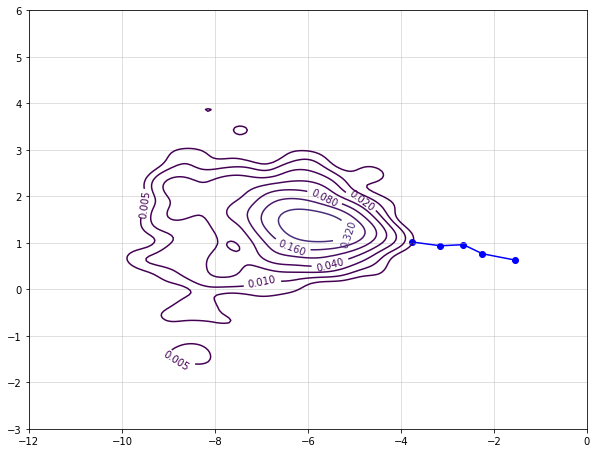

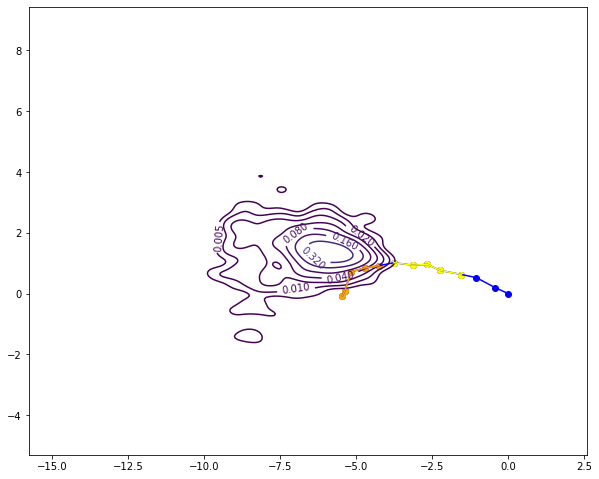

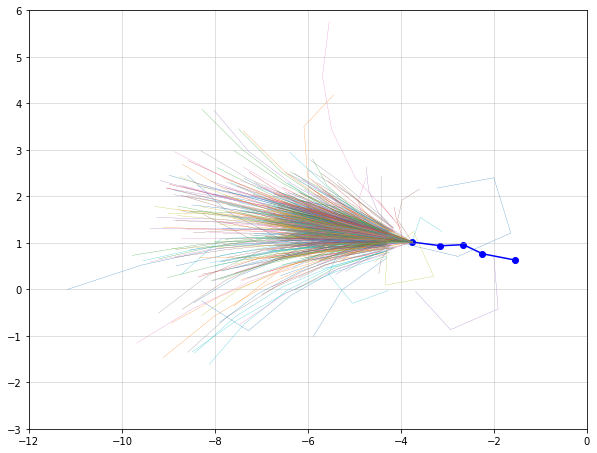

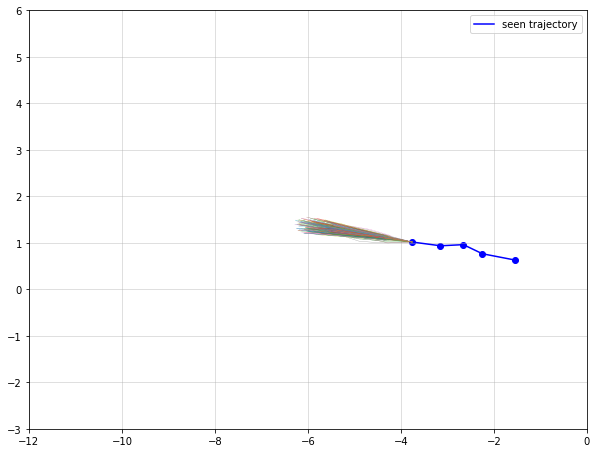

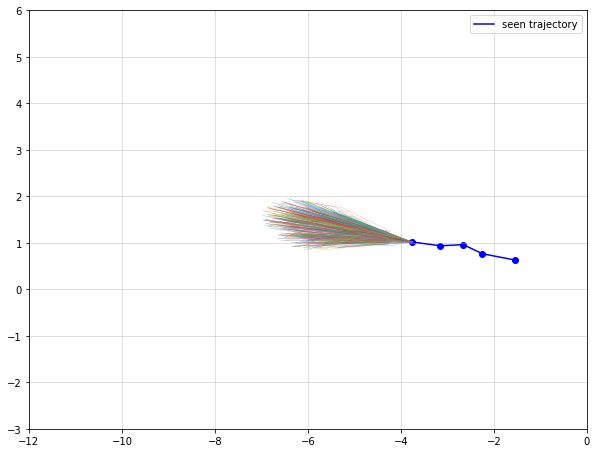

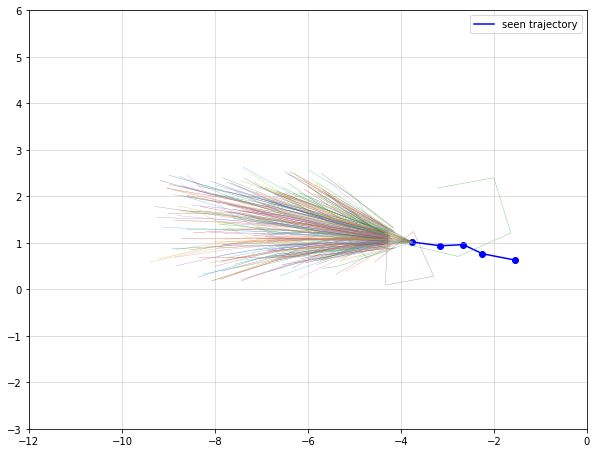

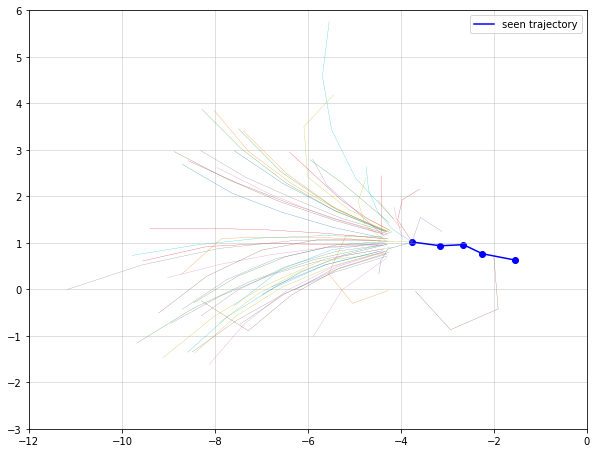

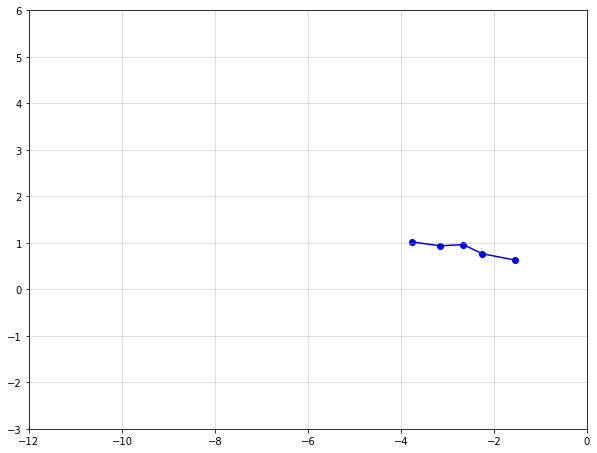

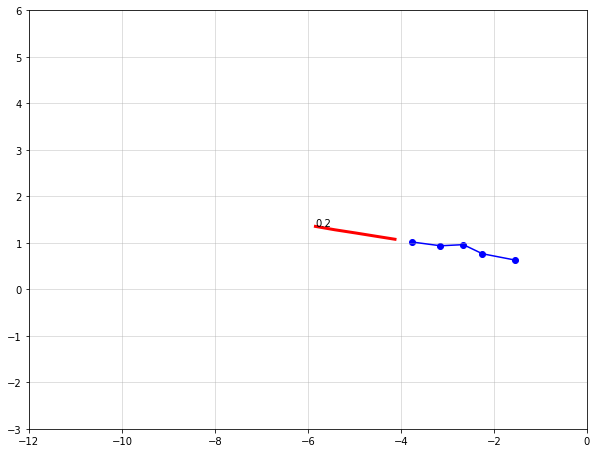

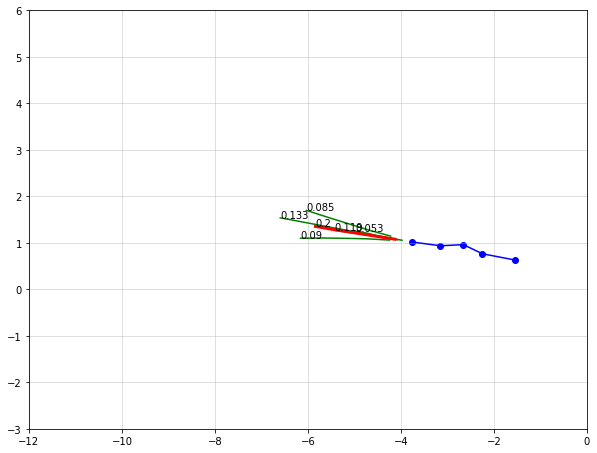

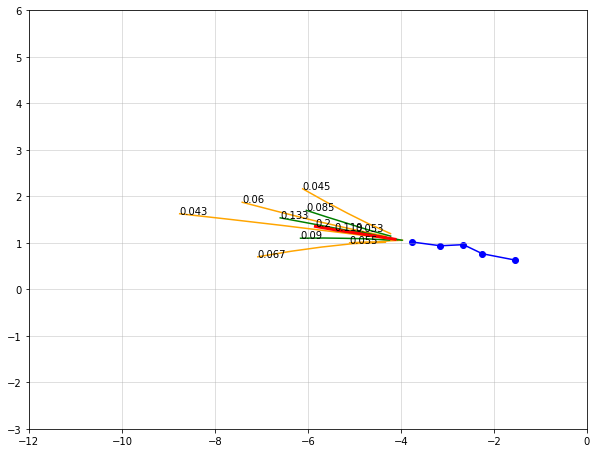

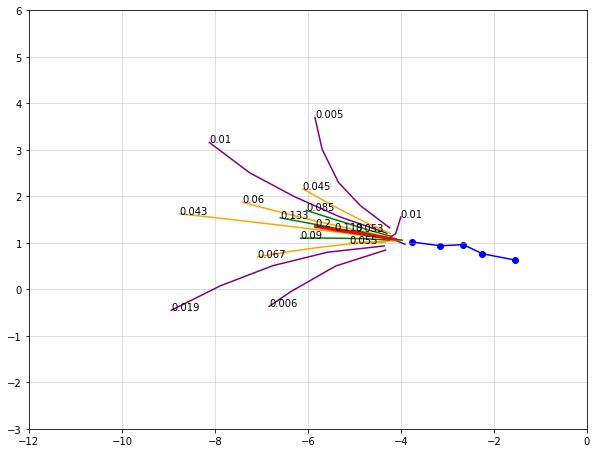

In [32]:
params = {
    "NOISE": 0.1,
    "NO_OF_TRAJECTORIES": 1000,
    "CONST_VEL_MODEL_PROB": 0.8,
    
    "STOP_PROB": 0.2,
    
    "DISCOUNT_AVG_PROB": 0.5,
    "DISCOUNT_LOWER_BOUND": 0.5,
    
    "VELOCITY_CHANGE_PROB": 0.2,
    "VELOCITY_CHANGE_NOISE": 0.1,
    
    "ANGLE_CHANGE_PROB": 0.05,
    "ANGLE_CHANGE_NOISE": 1,
    
    "CLUSTER_PERCENTAGES": [0.2, 0.68, 0.95, 1.0]
}

for agent_id in edinburgh_agent_ids[3:4]:
    print("Agent id: ", agent_id)
    x_data, y_data, max_train_idx = agent_data(edinburgh_data, agent_id)
    #start_idx = np.random.randint(0, max_train_idx)
    start_idx = 3
    print(start_idx)
    sample_x, sample_y, test_x, test_y = generate_data(edinburgh_data, start_idx, agent_id, 5)
        
    plotting_data = (x_data, y_data, start_idx)
    #plotting_data = None
    
    create_predicted_trajectories(sample_x, sample_y, params, plotting_data)
    if plotting_data != None:
        print("========================================================")